# N02 - Fully Supervised Training of LHCO AD datasets in Point Cloud Representation

## Step 1: Data Loading

- For the moment, data are loaded in memory instead of lazily.

In [1]:
import os
import awkward as ak
import tensorflow as tf

input_dir = "/pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/"
input_path = os.path.join(input_dir, "point_cloud_features_signal_plus_background.parquet")

2023-10-25 12:25:54.321816: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Check software version

In [2]:
print(f'awkward version     : {ak.__version__}')
print(f'tensorflow version  : {tf.__version__}')

awkward version     : 2.4.6
tensorflow version  : 2.12.1


### Check GPU device

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
#if len(physical_devices) > 0:
#    tf.config.experimental.set_memory_growth(physical_devices[0], True)
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
!nvidia-smi

Wed Oct 25 12:26:02 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-PCI...  On   | 00000000:C3:00.0 Off |                    0 |
| N/A   35C    P0    32W / 250W |      2MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Define class for loading point cloud dataset

In [5]:
from typing import Dict, List, Optional
import numpy as np
import copy

from quickstats import AbstractObject

class PointCloudDataset(AbstractObject):
    """
    This loader will load data in memory. Improvements to be made to load lazily.
    """
    DEFAULT_FEATURE_DICT = {
        "part_coords"   : ["part_delta_eta", "part_delta_phi"],
        "part_features" : ["part_pt", "part_delta_eta", "part_delta_phi", "part_delta_R"],
        "jet_features"  : ["jet_pt", "jet_eta", "jet_phi", "jet_m", "N", "tau12", "tau23"]
    }

    DEFAULT_LABEL_MAP = {
        "background" : 0,
        "signal"     : 1
    }
    
    def __init__(self, filename:str,
                 sample_sizes:Optional[Dict]=None,
                 label_map:Optional[Dict]=None,
                 feature_dict:Optional[Dict]=None,
                 num_jets:int=2, pad_size:int=300,
                 shuffle:bool=True, seed:int=2023,
                 balance_class_weight:bool=True,
                 verbosity:str="INFO"):
        super().__init__(verbosity=verbosity)
        if feature_dict is None:
            self.feature_dict = copy.deepcopy(self.DEFAULT_FEATURE_DICT)
        else:
            self.feature_dict = copy.deepcopy(feature_dict)
        if label_map is None:
            self.label_map = copy.deepcopy(self.DEFAULT_LABEL_MAP)
        else:
            self.label_map = copy.deepcopy(label_map)
        if sample_sizes is None:
            sample_sizes = {label: None for label in self.label_map}
        else:
            sample_sizes = {label: sample_sizes.get(label, None) for label in self.label_map}
        self.num_jets = num_jets
        self.pad_size  = pad_size
        self.sample_sizes = sample_sizes
        self.shuffle = shuffle
        self.seed = seed
        self._features = {}
        self._labels   = None
        self._weights  = None
        self.load(filename)

    def __len__(self):
        return self._labels.shape[0]
        
    @staticmethod
    def is_ragged(array):
        return isinstance(array.type.content, ak.types.ListType)

    @staticmethod
    def get_padded_array(array, pad_size:int, clip:bool=True, pad_val:float=0,
                         sample_size:Optional[int]=None):
        if sample_size is None:
            return ak.to_numpy(ak.fill_none(ak.pad_none(array, pad_size, clip=clip), pad_val))
        return ak.to_numpy(ak.fill_none(ak.pad_none(array[:sample_size], pad_size, clip=clip), pad_val))

    @staticmethod
    def get_array(array, sample_size:Optional[int]=None):
        if sample_size is None:
            return ak.to_numpy(array)
        return ak.to_numpy(array[:sample_size])
                  
    @staticmethod
    def get_mask_array(array, pad_size:int, clip:bool=True, sample_size:Optional[int]=None):
        if sample_size is None:
            return ak.to_numpy(ak.pad_none(array, pad_size, clip=clip)).mask
        return ak.to_numpy(ak.pad_none(array[:sample_size], pad_size, clip=clip)).mask

    def load(self, filename:str):
        self.stdout.info(f'Loading dataset from "{filename}"')
        ak_arrays = ak.from_parquet(filename)
        features = {}
        labels = []
        masks  = []
        weights = []
        np.random.seed(self.seed)
        for label, label_val in self.label_map.items():
            self.stdout.info(f'Preparing data for the class "{label}"')
            if label not in ak_arrays.fields:
                raise RuntimeError(f'dataset does not contain data with label "{label}"')
            label_arrays = ak_arrays[label]
            label_size = len(label_arrays)
            sample_size = self.sample_sizes[label]
            if (sample_size is not None):
                if sample_size > label_size:
                    raise RuntimeError('can not request more events than is available for the '
                                       f'class "{label}" (requested = {sample_size}, available = {label_size}')
                label_size = sample_size
            self.stdout.info(f'Size of class data: {label_size}')
            labels.append(np.full(label_size, label_val))
            weights.append(np.full(label_size, 1/label_size))
            mask_arrays = None
            for feature_type in self.feature_dict:
                self.stdout.info(f'Working on feature type "{feature_type}"')
                if feature_type not in features:
                    features[feature_type] = []
                columns = self.feature_dict[feature_type]
                jet_feature_arrays = []
                jet_mask_arrays = []
                for i in range(1, self.num_jets + 1):
                    self.stdout.info(f'Jet index: {i}')
                    jet_key = f'j{i}'
                    feature_arrays = []
                    mask_array = None
                    for column in columns:
                        self.stdout.info(f'Loading data for the feature "{column}"')
                        arrays = label_arrays[jet_key][column]
                        if self.is_ragged(arrays):
                            # only get the mask once per jet
                            if (mask_array is None):
                                mask_array = self.get_mask_array(arrays, self.pad_size,
                                                                 sample_size=sample_size)
                            arrays = self.get_padded_array(arrays, self.pad_size,
                                                           sample_size=sample_size)
                        else:
                            arrays = self.get_array(arrays, sample_size=sample_size)
                        feature_arrays.append(arrays)
                    # shape = (nevent, nparticles, nfeatuers)
                    feature_arrays = np.stack(feature_arrays, -1)
                    if mask_array is not None:
                        jet_mask_arrays.append(mask_array)
                    jet_feature_arrays.append(feature_arrays)
                # shape = (nevent, njet, nparticles, nfeatuers)
                jet_feature_arrays = np.stack(jet_feature_arrays, axis=1)
                features[feature_type].append(jet_feature_arrays)
                if jet_mask_arrays:
                    mask_arrays = np.stack(jet_mask_arrays, axis=1)
            if mask_arrays is not None:
                masks.append(mask_arrays)
        self.stdout.info(f'Combining data from all classes')
        sizes = []
        for feature_type in features:
            features[feature_type] = np.concatenate(features[feature_type])
            sizes.append(features[feature_type].shape[0])
        labels = np.concatenate(labels)
        weights = np.concatenate(weights)
        if len(set(sizes)) != 1:
            raise RuntimeError("inconsistent sample size in different feature types")
        if sizes[0] != labels.shape[0]:
            raise RuntimeError("inconsistent sample size between features and labels")
        if masks:
            masks  = np.concatenate(masks)
            assert masks.shape[0] == sizes[0]
        else:
            masks  = None
        if self.shuffle:
            self.stdout.info(f"Shuffling events (size = {sizes[0]})")
            index = np.arange(sizes[0])
            np.random.shuffle(index)
            for feature_type in features:
                features[feature_type] = features[feature_type][index]
            labels = labels[index]
            weights = weights[index]
            if masks is not None:
                masks = masks[index]
        if masks is not None:
            features['part_masks'] = masks
        labels = np.expand_dims(labels, axis=-1)
        weights = np.expand_dims(weights, axis=-1)
        self._features = features
        self._labels = labels
        self._weights = weights

    @property
    def X(self):
        return self._features
    
    @property
    def y(self):
        return self._labels

    @property
    def weight(self):
        return self._weights

    @property
    def masks(self):
        return self._masks

    def clear(self):
        self._features = None
        self._labels   = None
        self._weights  = None
        self._masks    = None

In [6]:
## change your dataset sizes here
#sample_sizes = {
#    "background": 1000,
#    "signal"    :  100
#}
sample_sizes = None
dataset = PointCloudDataset(input_path, sample_sizes=sample_sizes, shuffle=True, seed=2023)

[INFO] Loading dataset from "/pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/point_cloud_features_signal_plus_background.parquet"
[INFO] Preparing data for the class "background"
[INFO] Size of class data: 1000000
[INFO] Working on feature type "part_coords"
[INFO] Jet index: 1
[INFO] Loading data for the feature "part_delta_eta"
[INFO] Loading data for the feature "part_delta_phi"
[INFO] Jet index: 2
[INFO] Loading data for the feature "part_delta_eta"
[INFO] Loading data for the feature "part_delta_phi"
[INFO] Working on feature type "part_features"
[INFO] Jet index: 1
[INFO] Loading data for the feature "part_pt"
[INFO] Loading data for the feature "part_delta_eta"
[INFO] Loading data for the feature "part_delta_phi"
[INFO] Loading data for the feature "part_delta_R"
[INFO] Jet index: 2
[INFO] Loading data for the feature "part_pt"
[INFO] Loading data for the feature "part_delta_eta"
[INFO] Loading data for the feature "part_delta_phi"
[INFO] Loading data for the

In [7]:
# particle coordinates for the first event
print("Particle coordinates for the first jet for the first event\n")
print(f"Shape : {dataset.X['part_coords'][0][0].shape} = (nparticles, ncoordinates) ")
print(f"Data  : {dataset.X['part_coords'][0][0]}")

Particle coordinates for the first jet for the first event

Shape : (300, 2) = (nparticles, ncoordinates) 
Data  : [[ 0.08273684  0.96961395]
 [ 0.6298163   0.65206082]
 [ 0.46339107  0.77112841]
 [ 0.71120008  0.48612481]
 [-0.02538127  0.76314953]
 [ 0.34623092 -0.02559452]
 [ 0.12973251 -0.2797734 ]
 [ 0.00754225 -0.23905657]
 [ 0.19280946 -0.08275674]
 [ 0.16540136 -0.1139407 ]
 [ 0.14319258 -0.11612265]
 [ 0.15093603 -0.08423113]
 [ 0.15418371 -0.06084322]
 [ 0.1553969  -0.05245321]
 [ 0.13910487 -0.08679561]
 [ 0.13385388 -0.0648313 ]
 [ 0.11676263 -0.08941065]
 [ 0.13651484 -0.02939789]
 [ 0.11366623 -0.08791922]
 [ 0.07946598 -0.10332976]
 [ 0.10556989 -0.03993939]
 [ 0.062065   -0.10191791]
 [ 0.08274    -0.04024838]
 [ 0.06371027 -0.03582911]
 [ 0.05134832  0.01597746]
 [-0.06941975 -0.06152468]
 [ 0.04577159 -0.01918797]
 [-0.05511004  0.04230513]
 [-0.00283844  0.03128846]
 [-0.02372528 -0.0125541 ]
 [-0.02246136  0.00701828]
 [-0.03790647  0.00145997]
 [-0.03292662 -0.0025

In [8]:
# particle coordinates for the first event
print("Particle features for the second jet for the first event\n")
print(f"Shape : {dataset.X['part_features'][0][1].shape} = (nparticles, nfeatures) ")
print(f"Data  : {dataset.X['part_features'][0][1]}")

Particle features for the second jet for the first event

Shape : (300, 4) = (nparticles, nfeatures) 
Data  : [[ 0.96003884  0.5923312  -0.23249981  0.63632728]
 [ 3.70367289  0.02518051 -0.53423449  0.53482759]
 [ 3.24557805  0.14326927  0.25230006  0.29014031]
 ...
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]


In [9]:
# jet coordinates for the first event
print("Jet features for the first jet for the first event\n")
print(f"Shape : {dataset.X['jet_features'][0][1].shape} = (nfeatures) ")
print(f"Data  : {dataset.X['jet_features'][0][1]}")

Jet features for the first jet for the first event

Shape : (7,) = (nfeatures) 
Data  : [9.02213259e+02 3.01517878e-01 2.66001984e+00 8.14332938e+01
 5.40000000e+01 5.49103598e-01 7.32256369e-01]


In [10]:
## event weights (normalized such that sum of weight of each class is 1)
#print("Event weights\n")
#print(f"Shape : {dataset.weight.shape}")
#print(f"Data  : {dataset.weight}")

### Create train-validation-test splits

In [11]:
from aliad.data import split_dataset
from aliad.utils.system_utils import print_memory_usage

In [12]:
dataset_split = split_dataset(dataset.X, dataset.y, val_size=0.25, test_size=0.25, shuffle=True, random_state=2023)
# free up memory
dataset.clear()

In [13]:
print_memory_usage(dataset_split)

X_train:
    part_coords: 4.92 GB
    part_features: 9.83 GB
    jet_features: 58.75 MB
    part_masks: 314.71 MB
X_val:
    part_coords: 2.46 GB
    part_features: 4.92 GB
    jet_features: 29.37 MB
    part_masks: 157.36 MB
X_test:
    part_coords: 2.46 GB
    part_features: 4.92 GB
    jet_features: 29.37 MB
    part_masks: 157.36 MB
y_train: 4.20 MB
y_val: 2.10 MB
y_test: 2.10 MB
Total Memory Usage: 30.24 GB


32472000000

### Prepare dataset in tensorflow.data.Dataset format

In [14]:
from aliad.interface.tensorflow.dataset import prepare_dataset
batch_size = 32
train_ds = prepare_dataset(dataset_split['X_train']['part_coords'],
                           dataset_split['X_train']['part_features'],
                           dataset_split['X_train']['part_masks'],
                           dataset_split['X_train']['jet_features'],
                           y=dataset_split['y_train'],
                           batch_size=batch_size,
                           shuffle=True,
                           # can't set too high buffer size due to memory constraint
                           buffer_size=1024,
                           seed=2023)
val_ds = prepare_dataset(dataset_split['X_val']['part_coords'],
                         dataset_split['X_val']['part_features'],
                         dataset_split['X_val']['part_masks'],
                         dataset_split['X_val']['jet_features'],
                         y=dataset_split['y_val'],
                         batch_size=batch_size,
                         shuffle=False)
test_ds = prepare_dataset(dataset_split['X_test']['part_coords'],
                          dataset_split['X_test']['part_features'],
                          dataset_split['X_test']['part_masks'],
                          dataset_split['X_test']['jet_features'],
                          y=dataset_split['y_test'],
                          batch_size=batch_size,
                          shuffle=False)

2023-10-25 12:30:48.625739: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38219 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:c3:00.0, compute capability: 8.0


# Step 2: Create Modified ParticleNet Model 

In [15]:
from typing import Optional, Union, List, Tuple

import tensorflow as tf
from tensorflow.data import Dataset
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import (BatchNormalization, Activation,
                                     Conv3D, Dense, Dropout)

from quickstats import semistaticmethod, AbstractObject
from quickstats.utils.common_utils import combine_dict

from aliad.interface.tensorflow.layers import EdgeConv

class ModifiedParticleNet(AbstractObject):

    DEFAULT_CONFIG = {
        "num_points"  : 300,
        "num_jets"    : 2,
        "num_class"   : 1,
        "K"           : 16,
        "conv_params" : [(64, 64, 64),
                         (128, 128, 128),
                         (256, 256, 256)],
        "fc_params"   : [(256, 0.1)],
        "pool_method" : "average",
        "batchnorm"   : True,
        "activation"  : "relu"
    }
    
    def __init__(self, config:Optional[dict]=None,
                 verbosity:str="INFO"):
        super().__init__(verbosity=verbosity)
        self.config = combine_dict(self.DEFAULT_CONFIG, config)
    
    def get_model(self, points, features=None, masks=None,
                  jet_features=None, name='ParticleNet'):
        # points       : (nevent, njet, nparticle, ncoords)
        # features     : (nevent, njet, nparticle, nfeatures)
        # masks        : (nevent, njet, nparticle, 1)
        # jet_features : (nevent, njet, njetfeatures)
    
        with tf.name_scope(name):
            if features is None:
                features = points
    
            if masks is not None:
                coord_shift = tf.multiply(99., tf.cast(tf.expand_dims(masks, axis=-1), dtype='float32'))
            else:
                coord_shift = None
            fts = tf.expand_dims(features, axis=-2)
            fts = BatchNormalization(name=f"{name}_fts_bn")(fts)
            fts = tf.squeeze(fts, axis=-2)
            for layer_idx, layer_channels in enumerate(self.config['conv_params']):
                pts = points if layer_idx == 0 else fts
                if masks is not None:
                    pts = tf.add(coord_shift, pts)
                fts = EdgeConv(pts, fts, channels=layer_channels,
                               K=self.config['K'], 
                               batchnorm=self.config['batchnorm'],
                               activation=self.config['activation'],
                               pooling=self.config['pool_method'],
                               name=f'{name}_EdgeConv{layer_idx}')
    
            if masks is not None:
                fts_mask = tf.cast(tf.math.logical_not(tf.expand_dims(masks, axis=-1)), dtype='float32')
                fts = tf.multiply(fts, fts_mask)

            # shape = (nevent, njet, nchannel)
            pool = tf.reduce_mean(fts, axis=-2)
            if jet_features is not None:
                pool = tf.concat([pool, jet_features], -1)
            pool_shape = tf.shape(pool)
            out = tf.reshape(pool, (-1, tf.reduce_prod(pool_shape[1:])))
    
            if self.config['fc_params'] is not None:
                x = out
                for layer_idx, layer_param in enumerate(self.config['fc_params']):
                    units, drop_rate = layer_param
                    x = Dense(units, activation='relu')(x)
                    if drop_rate is not None and drop_rate > 0:
                        x = Dropout(drop_rate)(x)
                out = Dense(self.config['num_class'], activation='sigmoid')(x)
                
            inputs = [points, features]
            if masks is not None:
                inputs.append(masks)
            if jet_features is not None:
                inputs.append(jet_features)
        model = Model(inputs=inputs, outputs=out, name=name)
        return model

In [16]:
# for reproducibility
tf.random.set_seed(2023)
points        = Input(name='part_coords', shape=dataset_split['X_train']['part_coords'].shape[1:])
features      = Input(name='part_features', shape=dataset_split['X_train']['part_features'].shape[1:])
masks         = Input(name='part_masks', shape=dataset_split['X_train']['part_masks'].shape[1:], dtype='bool')
jet_features  = Input(name='jet_features', shape=dataset_split['X_train']['jet_features'].shape[1:])
model_builder = ModifiedParticleNet()
model = model_builder.get_model(points, features, masks=masks, jet_features=jet_features)

### Build tensorflow model

In [15]:
steps_per_epoch = dataset_split['y_train'].shape[0] / batch_size
config = {
    # for binary classification
    'loss'       : 'binary_crossentropy',
    'metrics'    : ['accuracy'],
    'epochs'     : 20,
    'optimizer'  : 'Adam',
    'optimizer_config': {
        'learning_rate': 0.001
    },
    'checkpoint_dir': '/pscratch/sd/c/chlcheng/model_checkpoints/LHCO_AD/fully_supervised/full_dataset_v3',
    'callbacks': {
        'lr_scheduler': {
            'initial_lr': 0.001,
            'lr_decay_factor': 0.5,
            'patience': 5,
            'min_lr': 1e-6
        },
        'early_stopping': {
            'monitor': 'val_loss',
            'patience': 3
        },
        'model_checkpoint':{
            'save_weights_only': True,
            # save model checkpoint every epoch
            'save_freq': int(steps_per_epoch * 1)
        }
    }
}

In [18]:
optimizer = tf.keras.optimizers.get({'class_name': config['optimizer'], 'config': config['optimizer_config']})
model.compile(loss=config['loss'],
              optimizer=optimizer,
              metrics=config['metrics'])

### Prepare callbacks

In [19]:
from aliad.interface.tensorflow.callbacks import LearningRateScheduler, BatchMetricsCallback
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

checkpoint_dir = config['checkpoint_dir']
import os
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

lr_scheduler = LearningRateScheduler(**config['callbacks']['lr_scheduler'])

early_stopping = EarlyStopping(**config['callbacks']['early_stopping'])

checkpoint = ModelCheckpoint(os.path.join(checkpoint_dir, 'model_weights_epoch_{epoch:02d}.h5'),
                             **config['callbacks']['model_checkpoint'])
batch_metrics = BatchMetricsCallback()
callbacks = [lr_scheduler, early_stopping, checkpoint, batch_metrics]

In [16]:
# free up memory
dataset_split['X_train'] = None
dataset_split['X_val'] = None
dataset_split['y_train'] = None
dataset_split['y_val'] = None

### Show model summary

In [21]:
model.summary()

Model: "ParticleNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 part_masks (InputLayer)        [(None, 2, 300)]     0           []                               
                                                                                                  
 tf.expand_dims (TFOpLambda)    (None, 2, 300, 1)    0           ['part_masks[0][0]']             
                                                                                                  
 tf.cast (TFOpLambda)           (None, 2, 300, 1)    0           ['tf.expand_dims[0][0]']         
                                                                                                  
 tf.math.multiply (TFOpLambda)  (None, 2, 300, 1)    0           ['tf.cast[0][0]']                
                                                                                        

# Step 3: Train Model

In [22]:
model.fit(train_ds,
          validation_data=val_ds,
          epochs=config['epochs'],
          callbacks=callbacks)

2023-10-25 01:07:58.638102: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype double and shape [550000,2,7]
	 [[{{node Placeholder/_3}}]]


Epoch 1/20


2023-10-25 01:08:03.886863: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8800
2023-10-25 01:08:07.082995: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


17187/17187 [==============================] - ETA: 0s - loss: 0.1911 - accuracy: 0.9699

2023-10-25 01:27:42.986859: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype bool and shape [275000,2,300]
	 [[{{node Placeholder/_2}}]]


17187/17187 [==============================] - 1502s 87ms/step - loss: 0.1911 - accuracy: 0.9699 - val_loss: 0.0667 - val_accuracy: 0.9776
Epoch 2/20
17187/17187 [==============================] - 1492s 87ms/step - loss: 0.0640 - accuracy: 0.9792 - val_loss: 0.0547 - val_accuracy: 0.9824
Epoch 3/20
17187/17187 [==============================] - 1519s 88ms/step - loss: 0.0589 - accuracy: 0.9807 - val_loss: 0.0512 - val_accuracy: 0.9828
Epoch 4/20
17187/17187 [==============================] - 1494s 87ms/step - loss: 0.0558 - accuracy: 0.9820 - val_loss: 0.0560 - val_accuracy: 0.9832
Epoch 5/20
17187/17187 [==============================] - 1500s 87ms/step - loss: 0.0536 - accuracy: 0.9825 - val_loss: 0.0543 - val_accuracy: 0.9804
Epoch 6/20
17187/17187 [==============================] - 1506s 88ms/step - loss: 0.0523 - accuracy: 0.9829 - val_loss: 0.0451 - val_accuracy: 0.9851
Epoch 7/20
17187/17187 [==============================] - 1517s 88ms/step - loss: 0.0513 - accuracy: 0.9834 - v

### Save model output

In [32]:
# save entire model
filename = os.path.join(config['checkpoint_dir'], "full_train_20_epoch.keras")
model.save(filename)

In [35]:
# save metrics history from training and evaluation
import json
metrics_history = {
    "train": batch_metrics.batch_train_metrics,
    "val": batch_metrics.batch_val_metrics,
}
filename = os.path.join(config['checkpoint_dir'], "metrics_history.json")
json.dump(metrics_history, open(filename, "w"))

## Model Testing

In [17]:
filename = os.path.join(config['checkpoint_dir'], "full_train_20_epoch.keras")
model = tf.keras.models.load_model(filename)

In [18]:
predicted_proba = model.predict(test_ds)

2023-10-25 12:31:15.189436: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype double and shape [275000,2,7]
	 [[{{node Placeholder/_3}}]]


   3/8593 [..............................] - ETA: 7:53  

2023-10-25 12:31:19.215769: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8800
2023-10-25 12:31:19.221277: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


8593/8593 [==============================] - 332s 38ms/step


In [19]:
y_pred = np.round(predicted_proba.flatten())

In [20]:
y_true = np.array([y for (x, y) in test_ds]).flatten()

In [21]:
accuracy = np.mean(y_true == y_pred)
accuracy

0.9864351797975096

In [22]:
from sklearn.metrics import accuracy_score, roc_auc_score, auc, roc_curve
fpr, tpr, _ = roc_curve(y_true, predicted_proba.flatten())
roc_auc = auc(fpr, tpr)
roc_auc

0.9941666023909488

### Evaluate Error from Bootstrapping

In [23]:
def get_bootstrap_prediction(*X, y,  model, num_bootstrap_samples:int=20):
    bootstrap_predictions = []
    sample_size = y.shape[0]
    for _ in range(num_bootstrap_samples):
        # Sampling with replacement
        bootstrap_indices = np.random.choice(sample_size, sample_size, replace=True)
        bootstrap_dataset = prepare_dataset(*[x[bootstrap_indices]  for x in X],
                                            y=y[bootstrap_indices],
                                            batch_size=32,
                                            shuffle=False)
        predicted_proba = model.predict(bootstrap_dataset).flatten()
        bootstrap_predictions.append(predicted_proba)
    return bootstrap_predictions

In [24]:
# TO-RUN Later
if False:
    bootstrap_predictions = get_bootstrap_prediction(dataset_split['y_test']['part_coords'],
                                                     dataset_split['y_test']['part_features'],
                                                     dataset_split['y_test']['part_masks'],
                                                     dataset_split['y_test']['jet_features'],
                                                     y=dataset_split['y_test'],
                                                     model=model, num_bootstrap_samples=20)

## Visualization

### Loss, Accuracy Curves

In [25]:
import json
import pandas as pd
filename = os.path.join(config['checkpoint_dir'], "metrics_history.json")
metrics_history = json.load(open(filename))
num_epochs = 13
dfs = {}
for key, value in metrics_history.items():
    dfs[key] = pd.DataFrame(value)
    steps_per_epoch = dfs[key].shape[0] // num_epochs
    dfs[key]['epoch'] = (dfs[key].index + 1) / steps_per_epoch

In [65]:
from quickstats.plots import General1DPlot
label_map = {
    'train': 'Train',
    'val': 'Validation'
}
analysis_label_options = {
    'colab': 'ATLAS',
    'status': '', 
    'energy' : None, 
    'lumi' : None,
    'loc': (0.1, 0.9),
    'extra_text': 'LHC Olympics 2020 dataset//Fully Supervised with Low Level Features'
}
styles = {
    'legend': {
        'loc': (0.7, 0.8)
    }
}
plotter = General1DPlot(dfs, color_cycle='checker',
                        label_map=label_map, styles=styles,
                        analysis_label_options=analysis_label_options)

<Axes: xlabel='Epoch', ylabel='Loss'>

<Figure size 640x480 with 0 Axes>

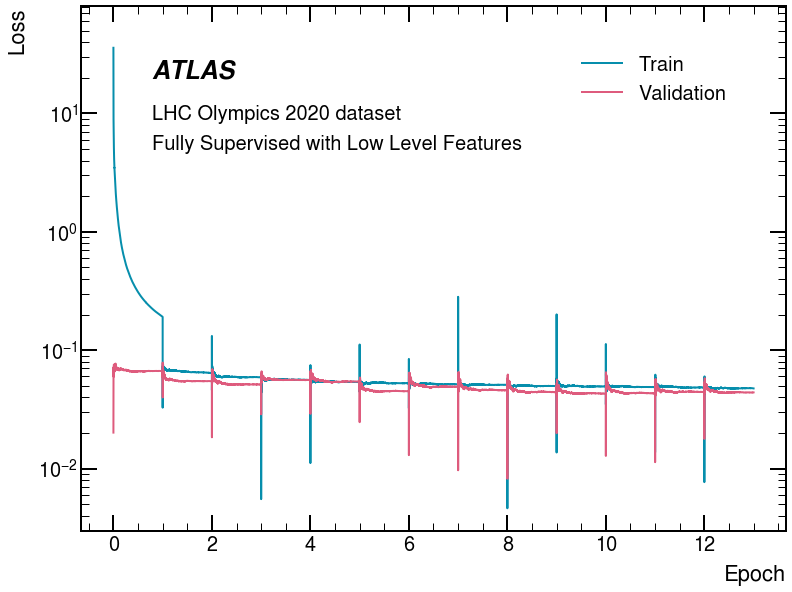

In [66]:
plotter.draw('epoch', 'loss', logy=True, xlabel='Epoch', ylabel='Loss')

<Axes: xlabel='Epoch', ylabel='Accuracy'>

<Figure size 640x480 with 0 Axes>

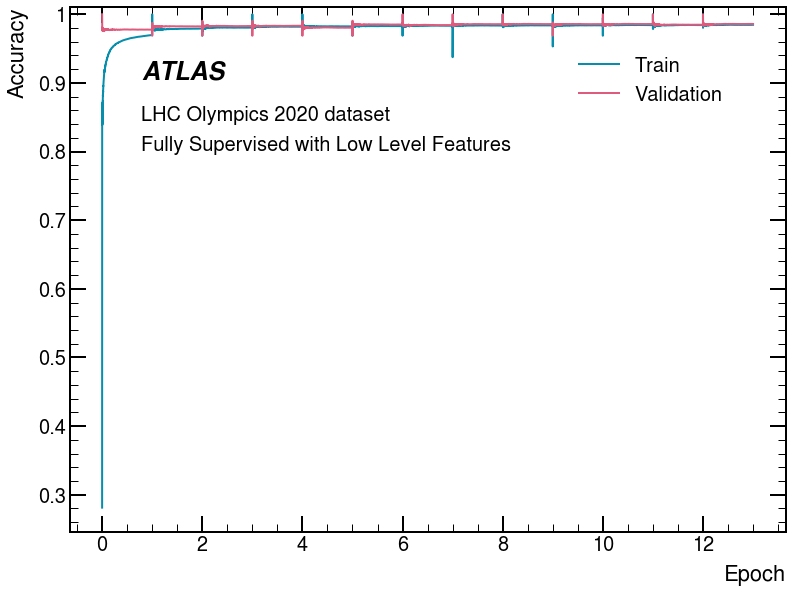

In [67]:
plotter.draw('epoch', 'accuracy', xlabel='Epoch', ylabel='Accuracy', ymax=1.01)

### model output (score) distribution

In [70]:
sig_mask = y_true == 1
bkg_mask = y_true == 0
dfs = {
    'Signal'     : pd.DataFrame({"score": predicted_proba.flatten()[sig_mask]}),
    'Background' : pd.DataFrame({"score": predicted_proba.flatten()[bkg_mask]})
}

In [78]:
from quickstats.plots import VariableDistributionPlot
analysis_label_options = {
    'colab': 'ATLAS',
    'status': '', 
    'energy' : None, 
    'lumi' : None,
    'loc': (0.12, 0.9),
    'extra_text': 'LHC Olympics 2020 dataset//Fully Supervised with Low Level Features'
}
styles = {
    'legend': {
        'loc': (0.65, 0.8)
    }
}
plotter = VariableDistributionPlot(dfs, color_cycle='checker',
                                   styles=styles, analysis_label_options=analysis_label_options)

<Axes: xlabel='Predicted Prob.', ylabel='Fraction of Events / 0.04'>

<Figure size 640x480 with 0 Axes>

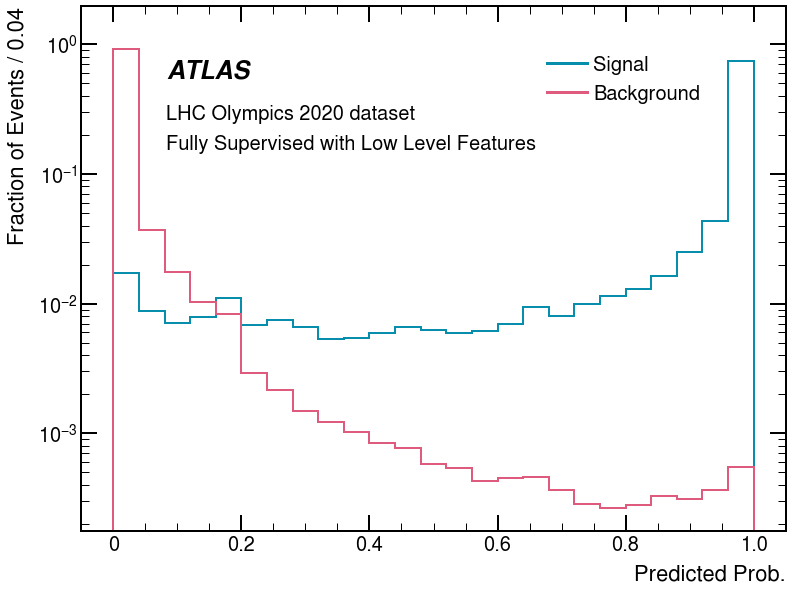

In [79]:
plotter.draw('score', xlabel='Predicted Prob.', bin_range=(0, 1), logy=True)

### AUC Curve

In [87]:
analysis_label_options = {
    'colab': 'ATLAS',
    'status': '', 
    'energy' : None, 
    'lumi' : None,
    'loc': (0.1, 0.9),
    'extra_text': f'LHC Olympics 2020 dataset//Fully Supervised with Low Level Features//AUC = {roc_auc:.3f}'
}
df = pd.DataFrame({"fpr": fpr, "tpr": tpr})
plotter = General1DPlot(df, color_cycle='checker',
                        analysis_label_options=analysis_label_options)

<Axes: xlabel='FPR', ylabel='TPR'>

<Figure size 640x480 with 0 Axes>

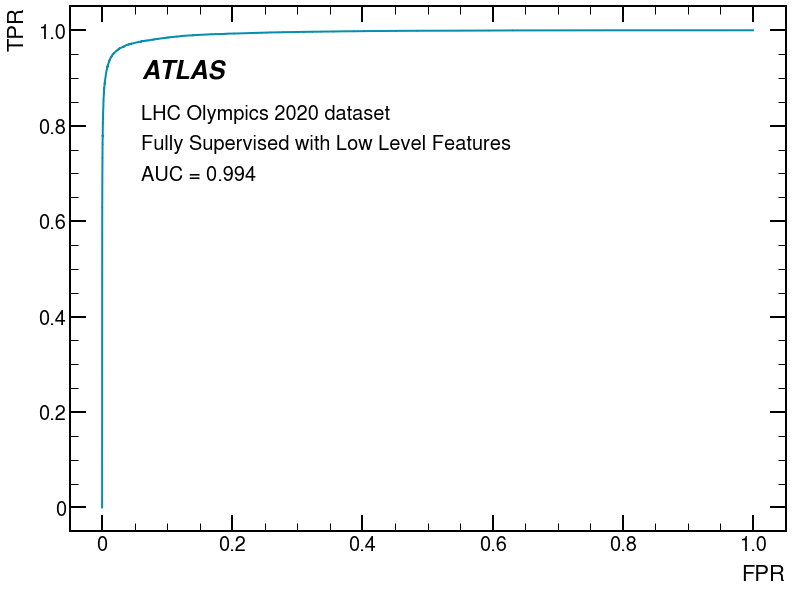

In [88]:
plotter.draw("fpr", "tpr", ymax=1.05, xlabel="FPR", ylabel="TPR")

### Event display

In [89]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import math
def display_event_image(x_features, x_masks, y, y_pred, indices=None,
                        ncol=4, dpi=72, figsize=(20, 8), alpha=0.5):
    if indices is not None:
        x_features = x_features[indices]
        x_masks = x_masks[indices]
        y, y_pred = y[indices], y_pred[indices]
    batchsize = x_features.shape[0]
    nrows = math.ceil(batchsize/ncol)
    for i in range(nrows):
        fig, axes = plt.subplots(nrows=2, ncols=ncol, dpi=dpi,
                                 facecolor='#FFFFFF', figsize=figsize)
        for j in range(ncol):
            idx = i * ncol + j
            if idx >= batchsize:
                break
            label, label_pred = y[idx], y_pred[idx]
            color = 'green' if (label == label_pred) else 'red'
            title = 'QCD Dijet' if label == 0 else "W'"
            for jet_idx in [0, 1]:
                masks = ~x_masks[idx][jet_idx]
                x = x_features[idx][jet_idx][masks]
                pT  = x[:, 0]
                eta = x[:, 1]
                phi = x[:, 2]
                ax = axes[jet_idx][j]
                ax.scatter(eta, phi, pT, alpha=alpha)
                ax.xaxis.set_major_locator(ticker.NullLocator())
                ax.yaxis.set_major_locator(ticker.NullLocator())
                for spine in ax.spines.values():
                    spine.set_edgecolor(color)
                    spine.set_linewidth(1)
                if jet_idx == 0:
                    ax.set_title(title, fontsize=20, fontweight="bold")
        plt.subplots_adjust(wspace=None, hspace=0, top=0.90)

In [90]:
x_features = dataset_split['X_test']['part_features']
x_masks    = dataset_split['X_test']['part_masks']

/tmp/ipykernel_1036835/2755562156.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(nrows=2, ncols=ncol, dpi=dpi,


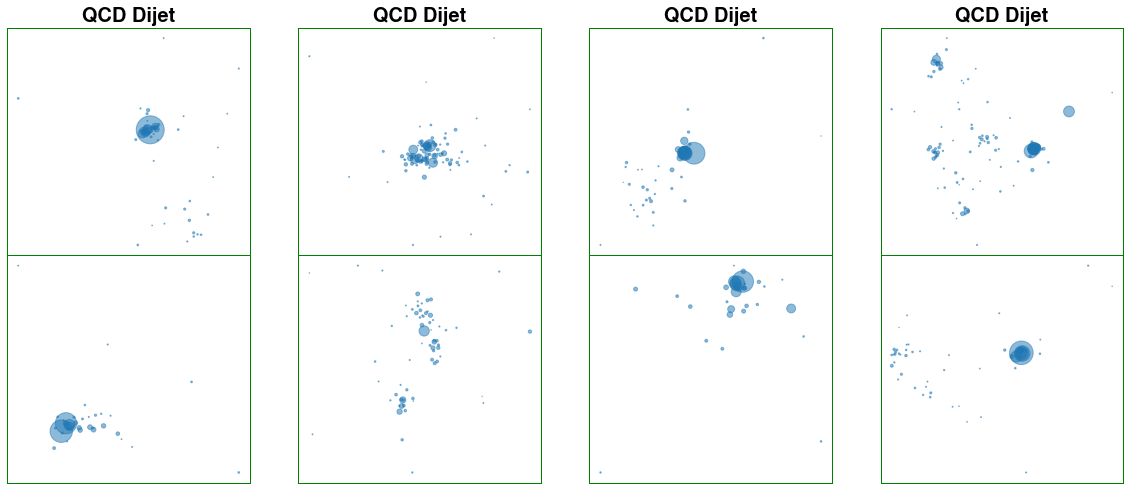

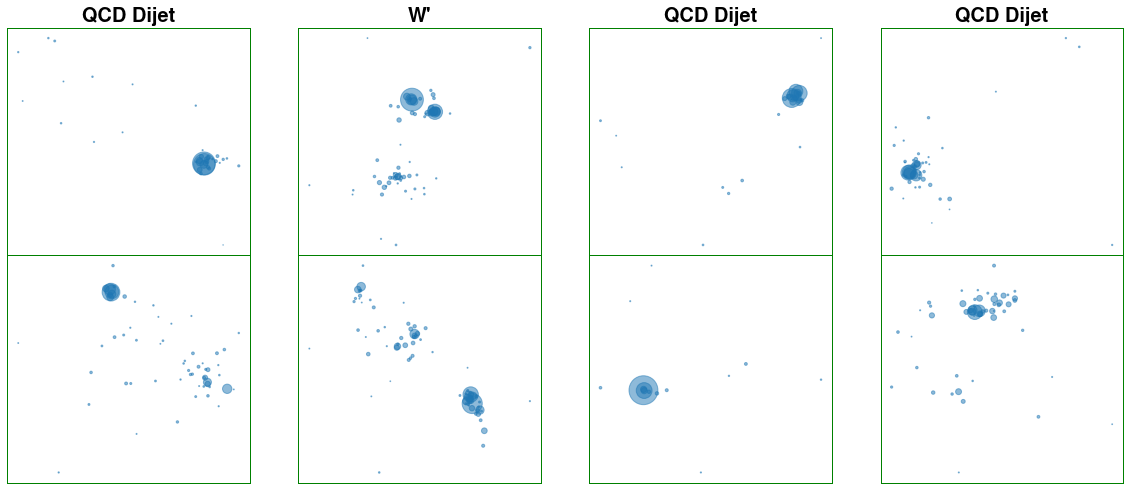

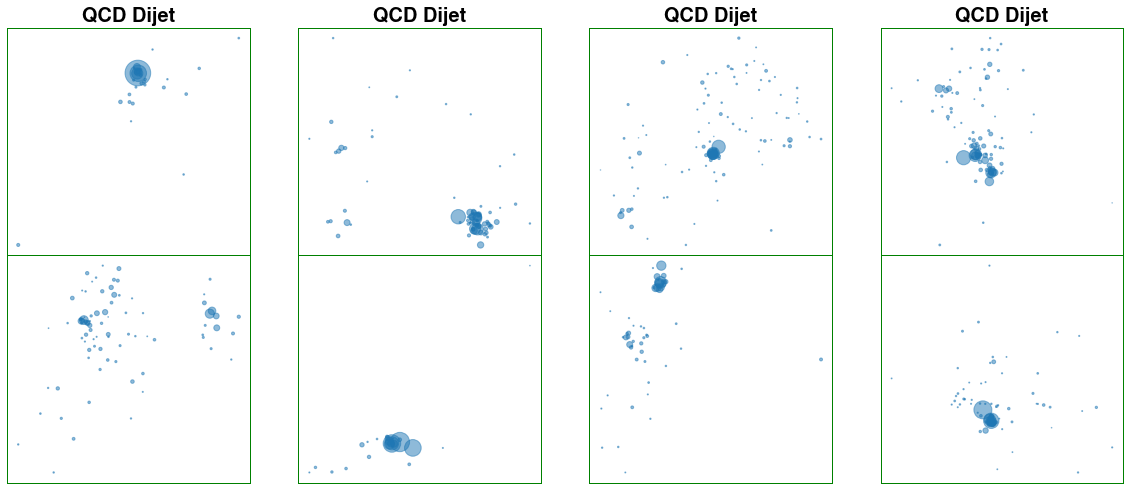

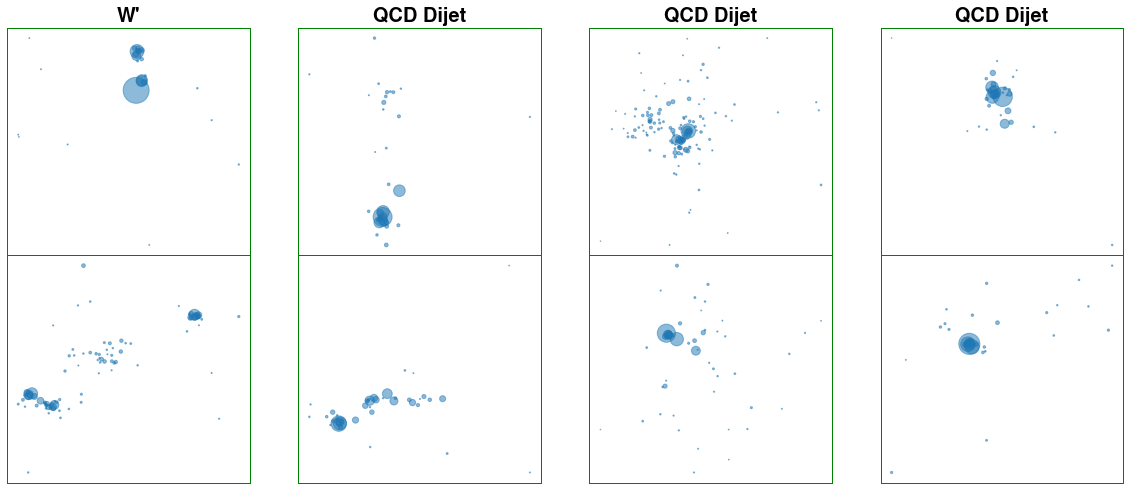

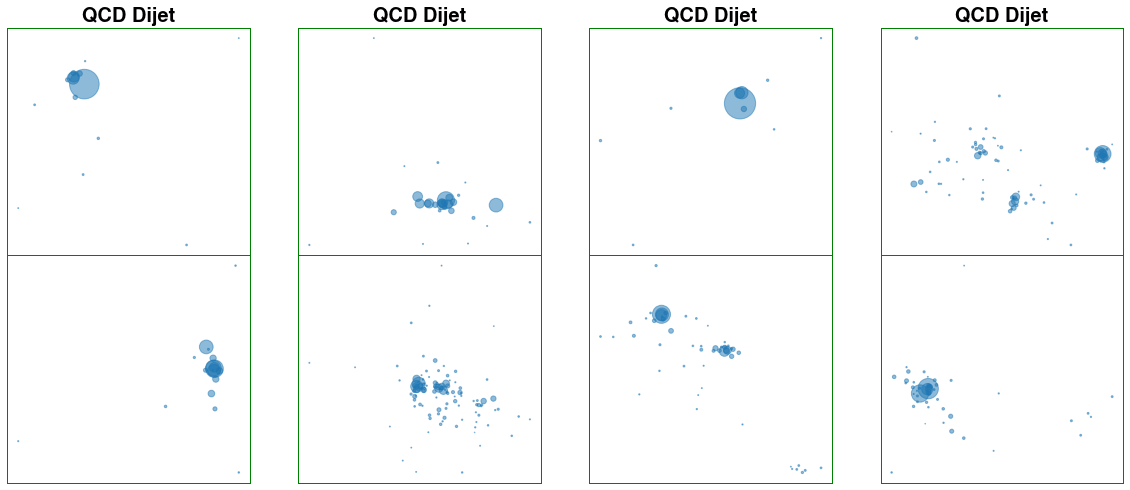

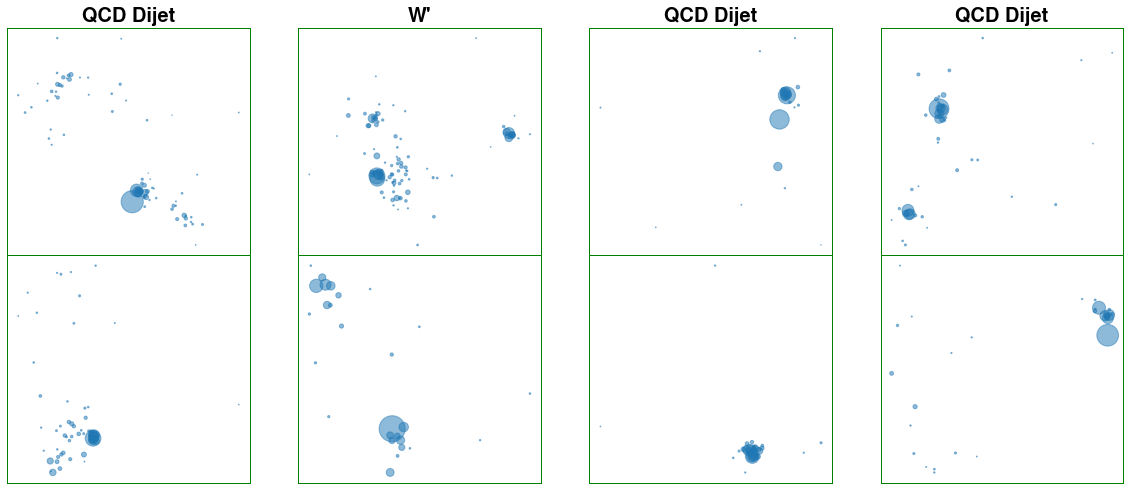

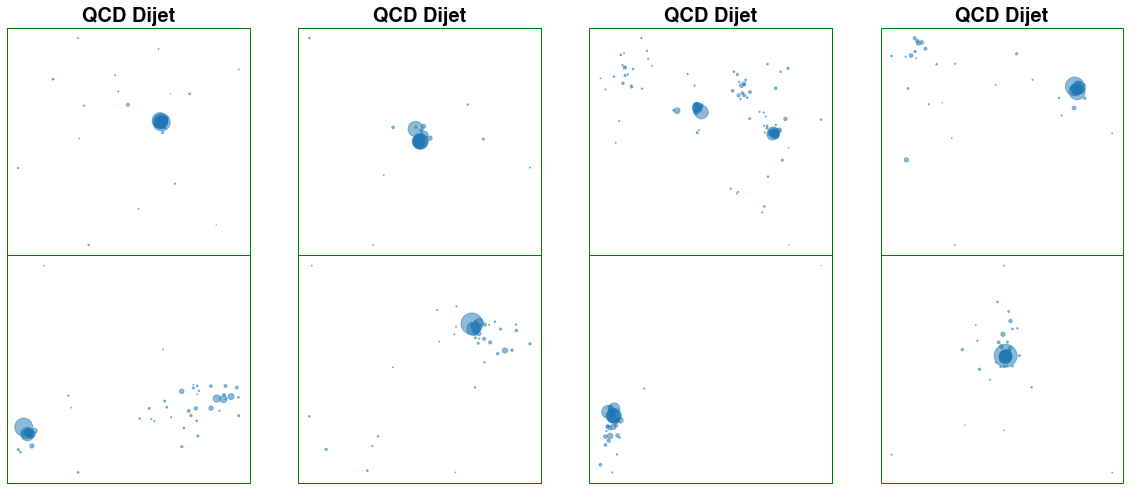

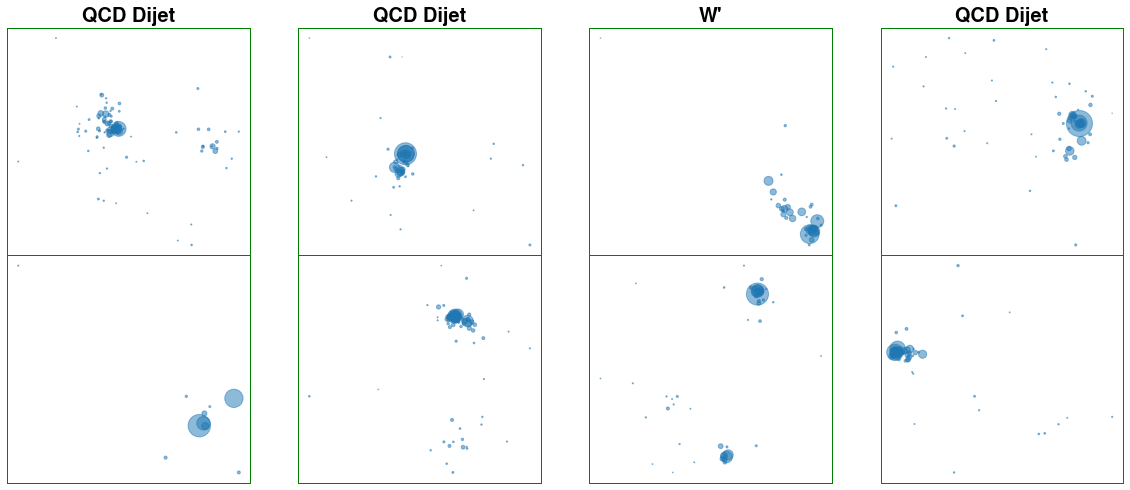

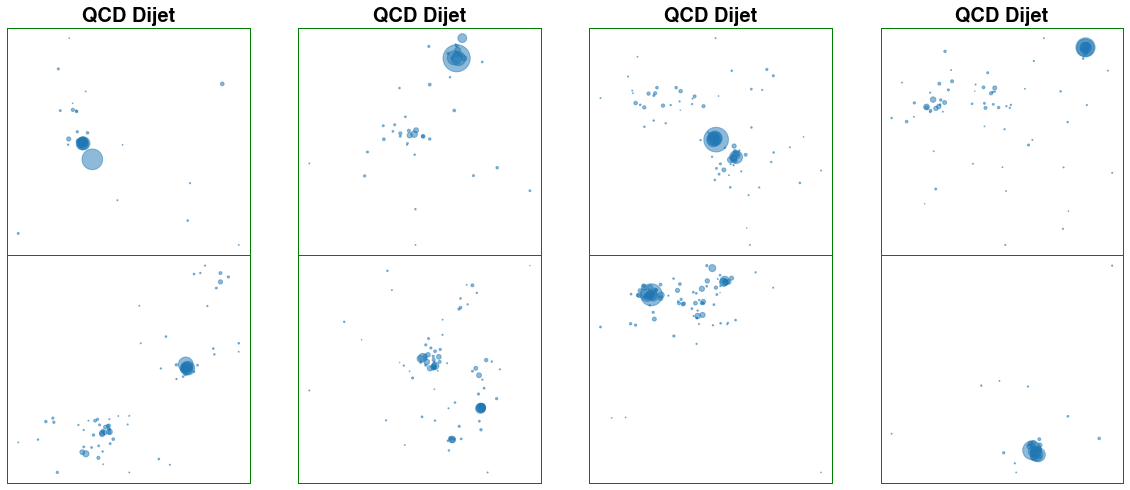

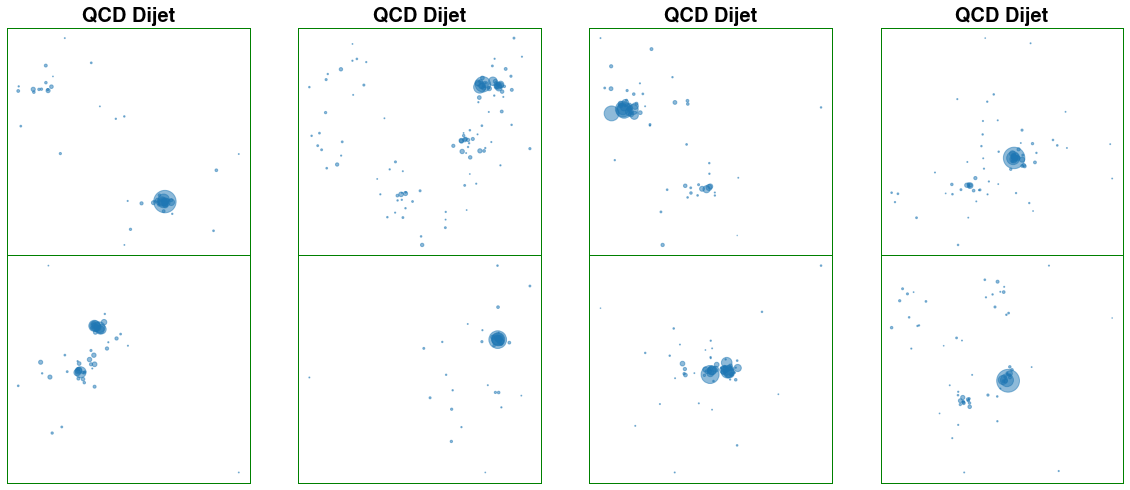

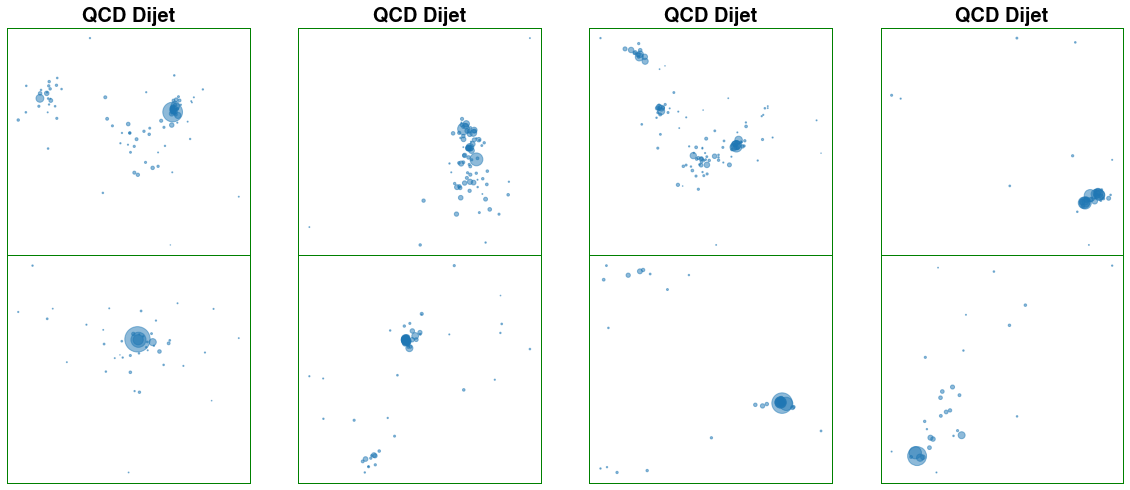

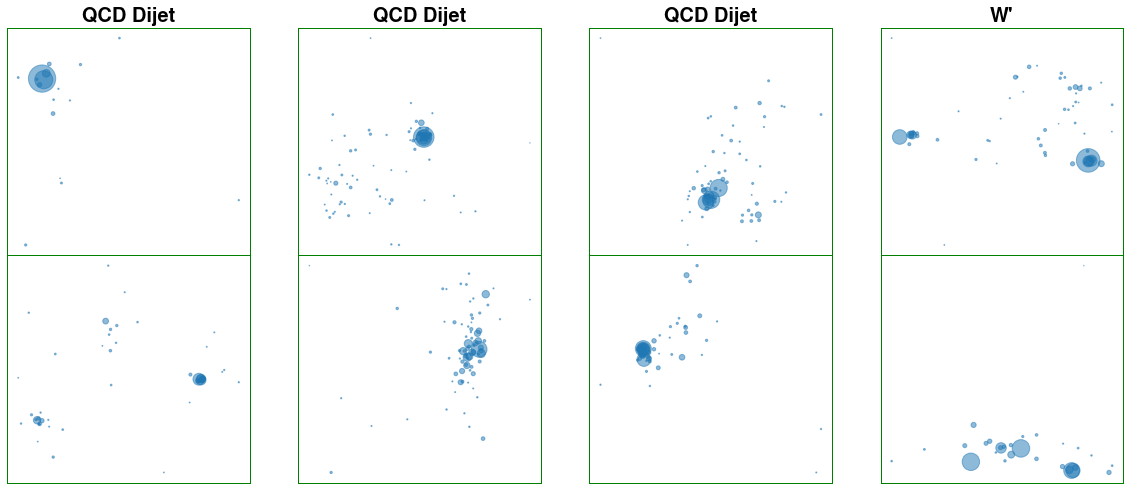

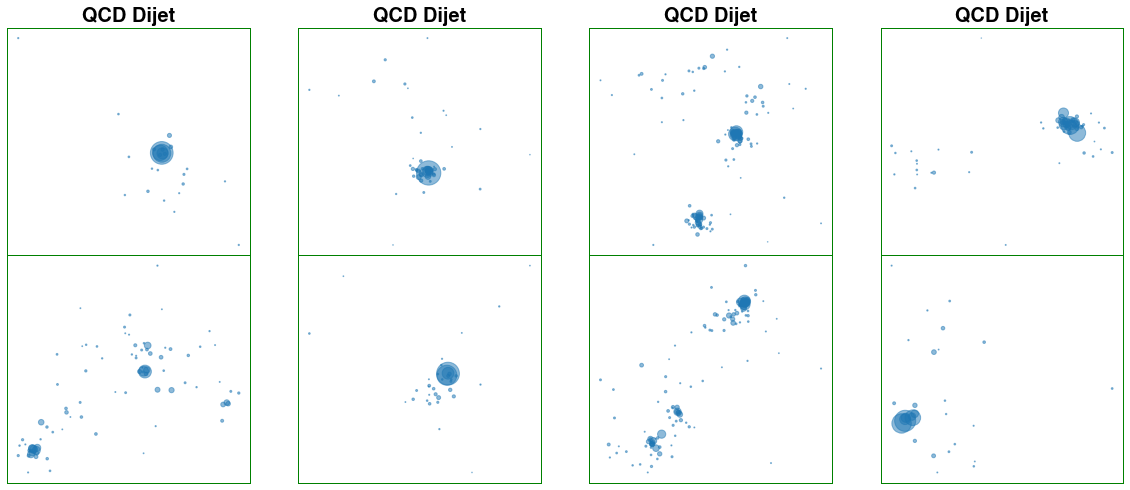

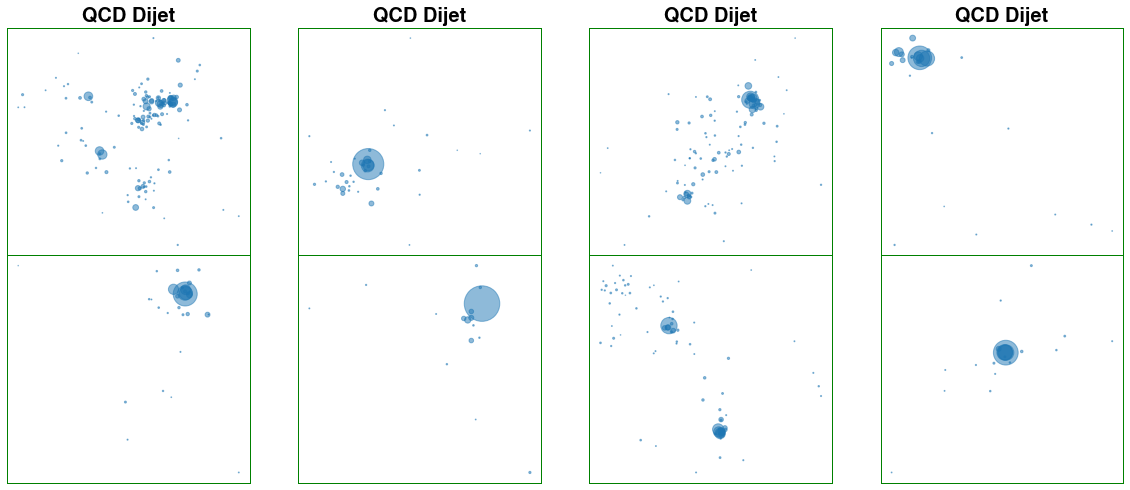

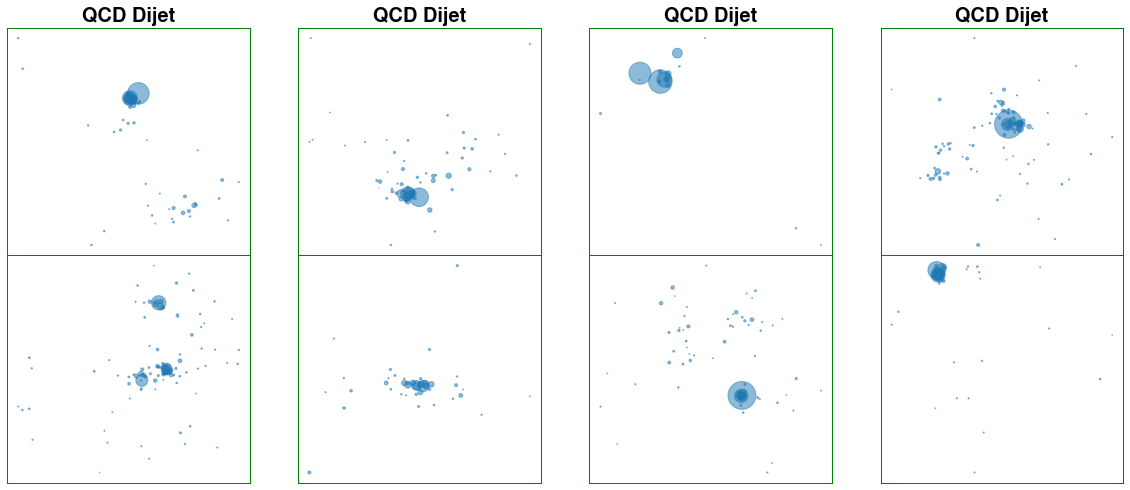

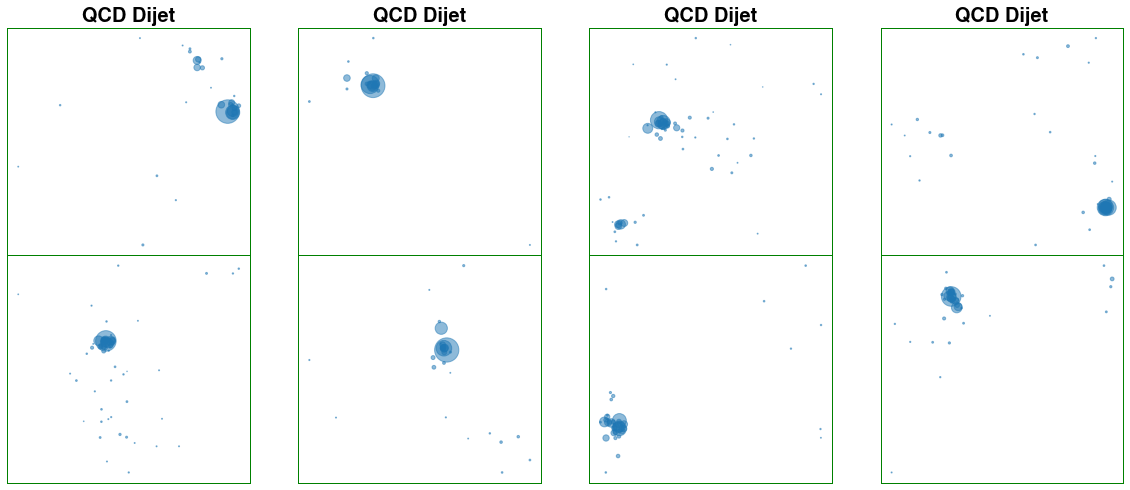

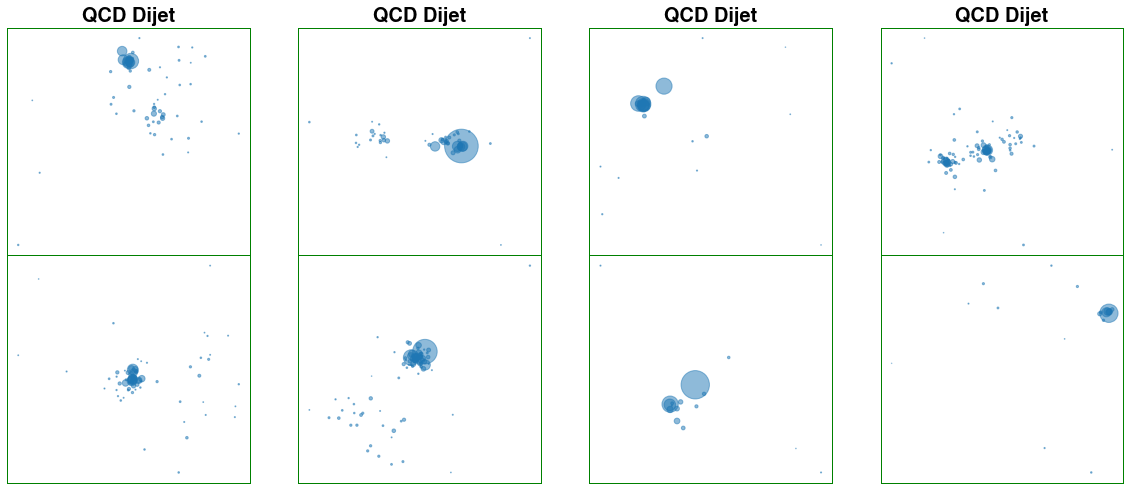

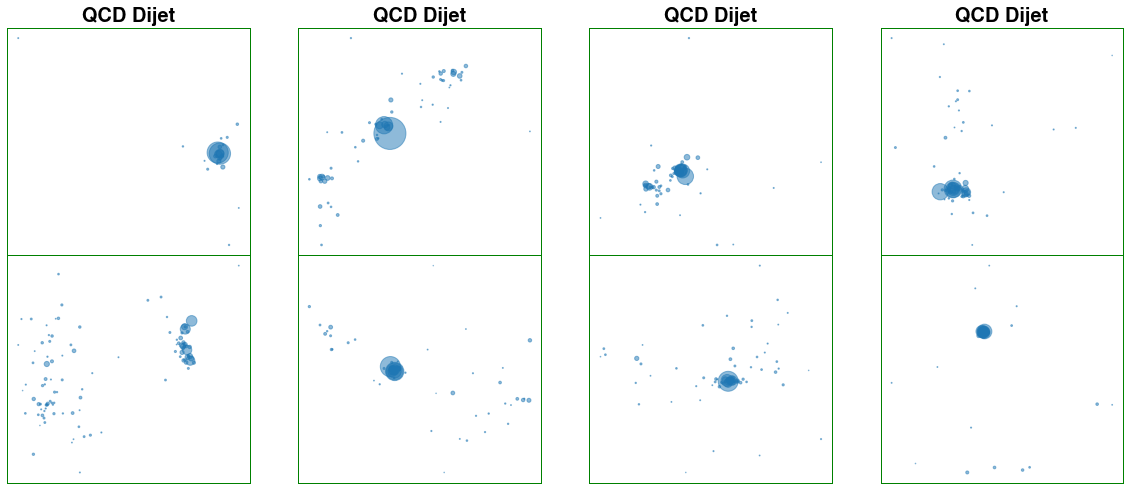

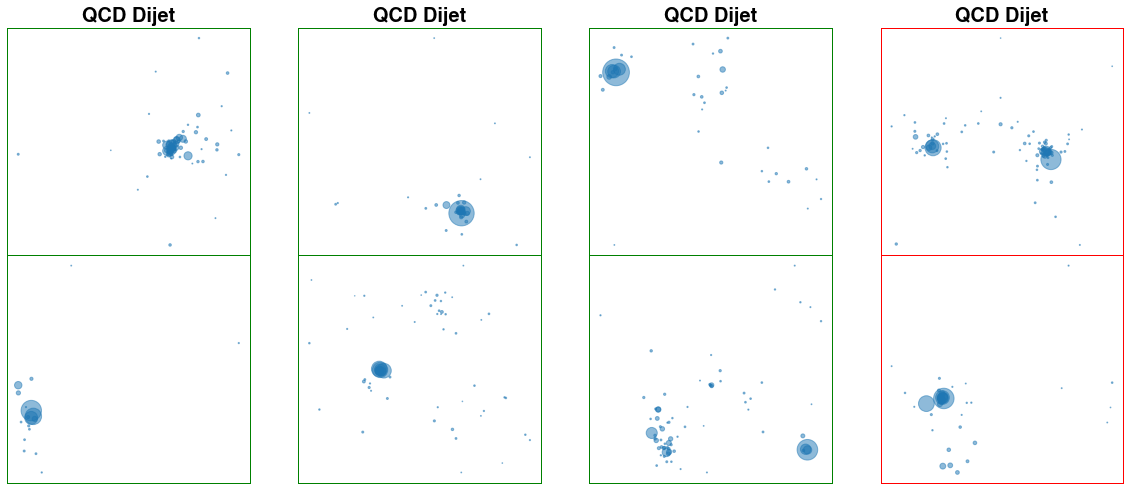

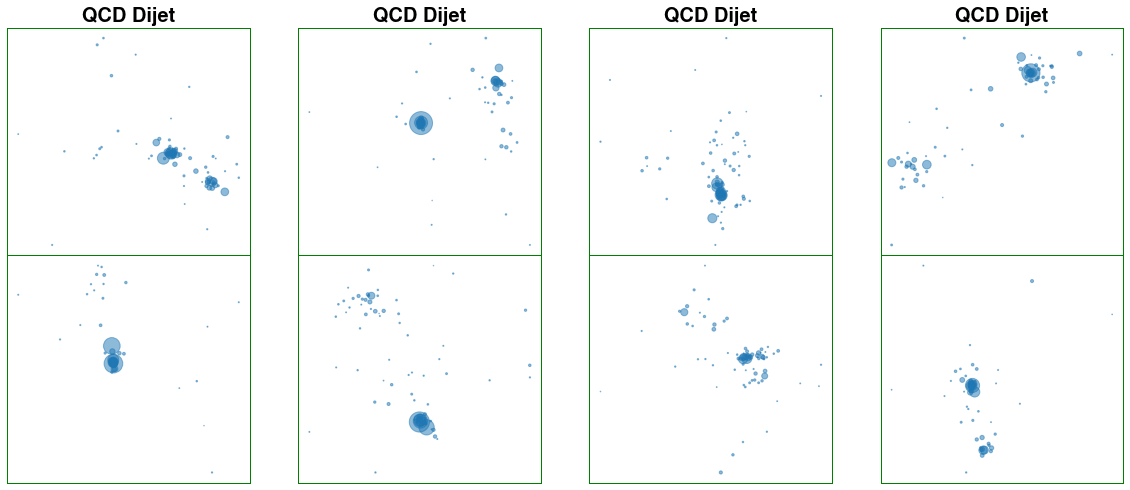

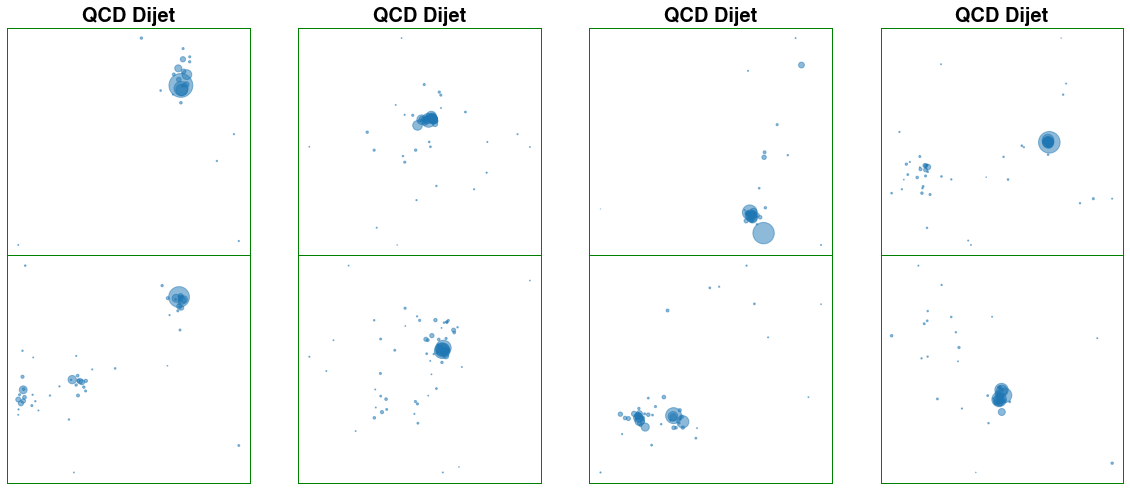

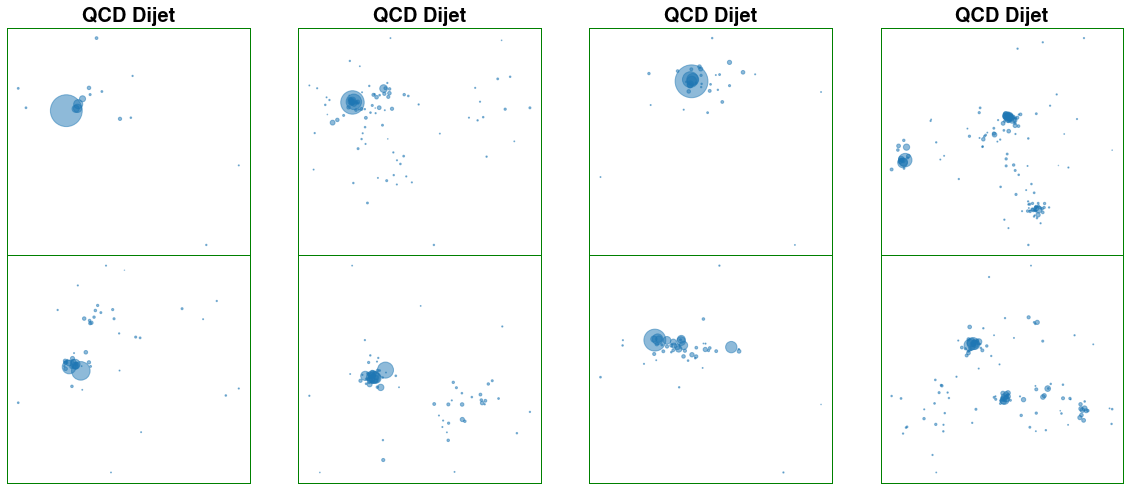

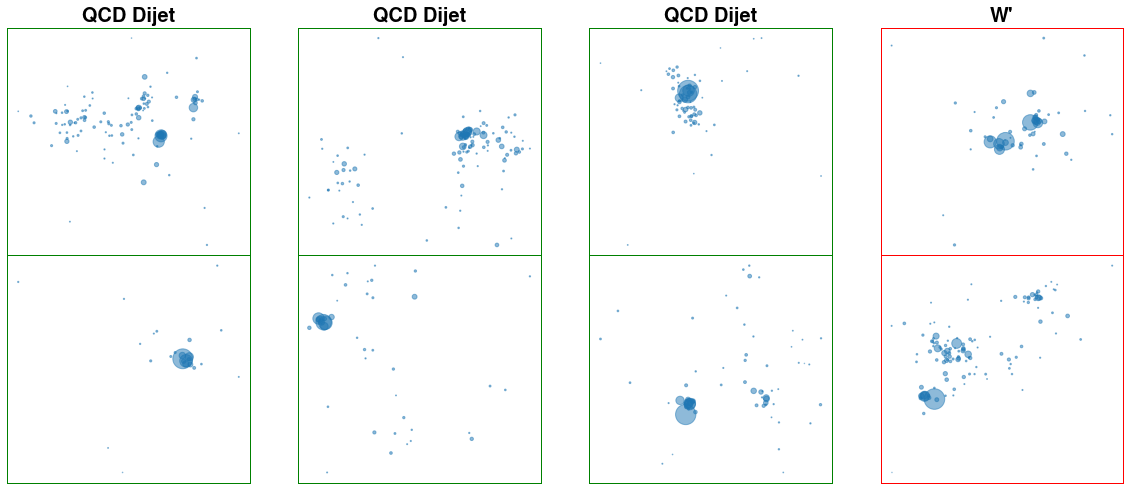

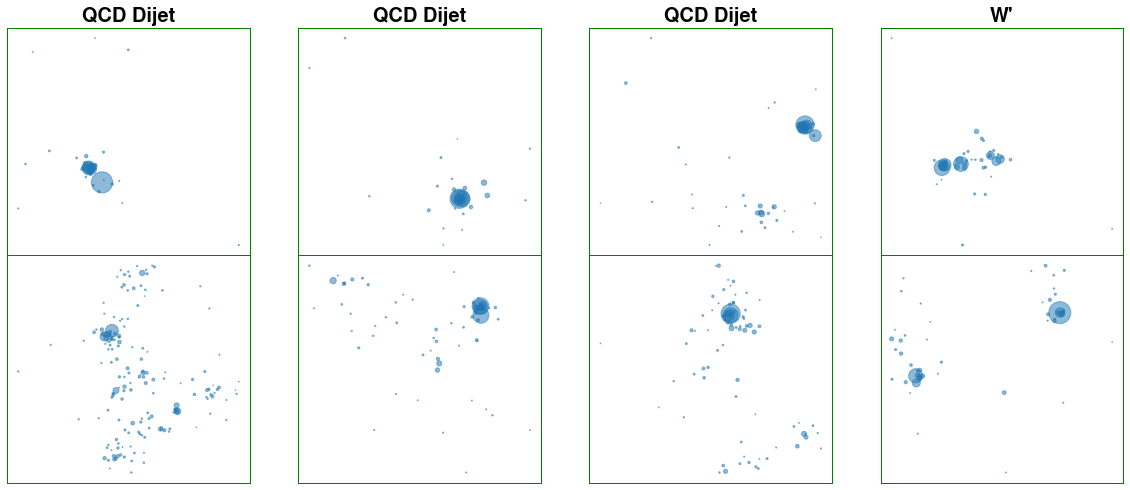

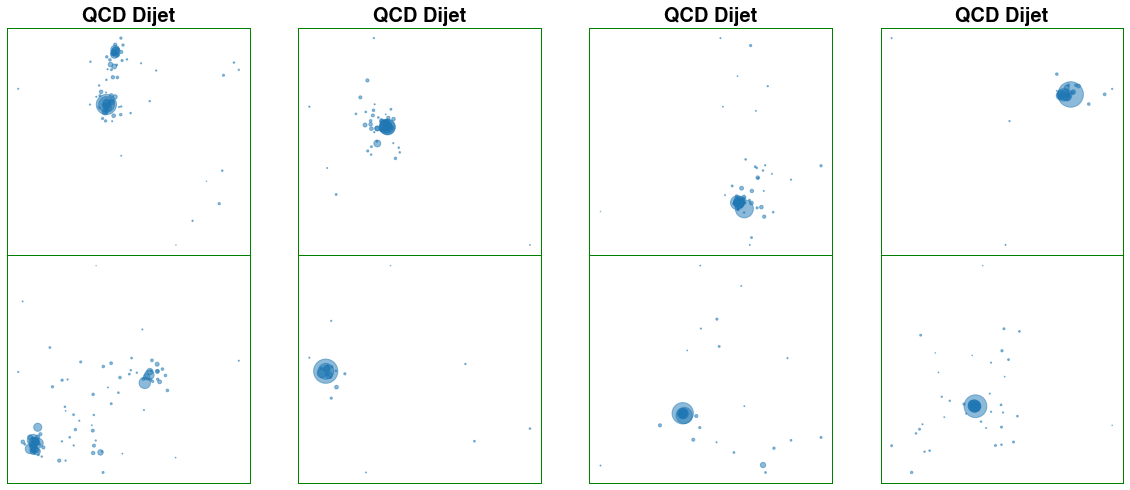

In [92]:
# show 200 events, I make the range such that there exists at least one wrongly labelled event
# those framed in green are correctly labelled, and those in red are incorrectly labelled
events_to_show = np.arange(1000)[200:400]
display_event_image(x_features, x_masks, y_true, y_pred, events_to_show)